In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import math
import numpy as np

Using TensorFlow backend.


In [2]:
(X_Train,_),(_,_) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [3]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*X_Train.shape, 1))
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [4]:
# Normalize the Data between -1 and 1

X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [0]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH = int(BATCH_SIZE/2)

NOISE_DIM = 100

# Use these Adam Params for GAN's
adam = Adam(lr=2e-4, beta_1=0.5)

In [8]:
# Generator

generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double Activation Size (14 * 14 * 64)
generator.add(Conv2DTranspose(64, kernel_size=(5,5),strides=(2,2), padding='same'))
# stride here helps to increase the input size
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double Activation Size (28 * 28 * 1)
generator.add(Conv2DTranspose(1, kernel_size=(5,5),strides=(2,2), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer='adam')
generator.summary()

W0831 14:42:55.056101 140605192877952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 14:42:55.079462 140605192877952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

In [9]:
# Discriminator

discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Next Conv Layer (14 x 14 x 64)
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))

# Flatten
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [10]:
# GAN (Step-2)
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input, gan_output)
model.compile(loss='binary_crossentropy', optimizer=adam)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [0]:
def save_images(epoch, samples=100):
    
    noise = np.random.normal(0,1,size=(samples, NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i], interpolation='nearest', cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.savefig('images/dcgan_tc_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

In [0]:
!mkdir images
!mkdir model

In [0]:
!ls

images	model  sample_data


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 -> Discriminator Loss : 0.3547 & Generator Loss : 3.6832
Epoch 2 -> Discriminator Loss : 0.5375 & Generator Loss : 2.1006
Epoch 3 -> Discriminator Loss : 0.4215 & Generator Loss : 2.2092
Epoch 4 -> Discriminator Loss : 0.4305 & Generator Loss : 2.3571
Epoch 5 -> Discriminator Loss : 0.4894 & Generator Loss : 2.1192


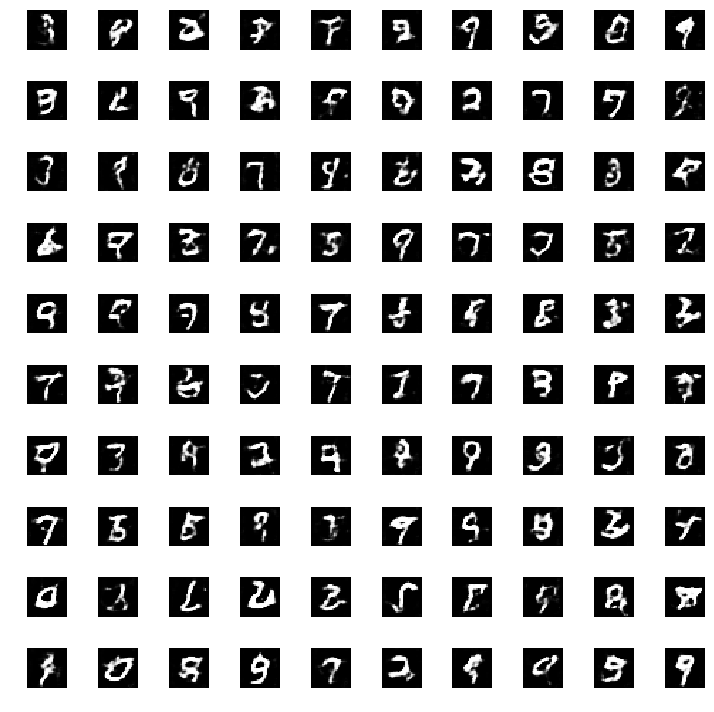

Epoch 6 -> Discriminator Loss : 0.5097 & Generator Loss : 1.9746
Epoch 7 -> Discriminator Loss : 0.5059 & Generator Loss : 1.9153
Epoch 8 -> Discriminator Loss : 0.5286 & Generator Loss : 1.8932
Epoch 9 -> Discriminator Loss : 0.5081 & Generator Loss : 1.8629
Epoch 10 -> Discriminator Loss : 0.5049 & Generator Loss : 1.9096


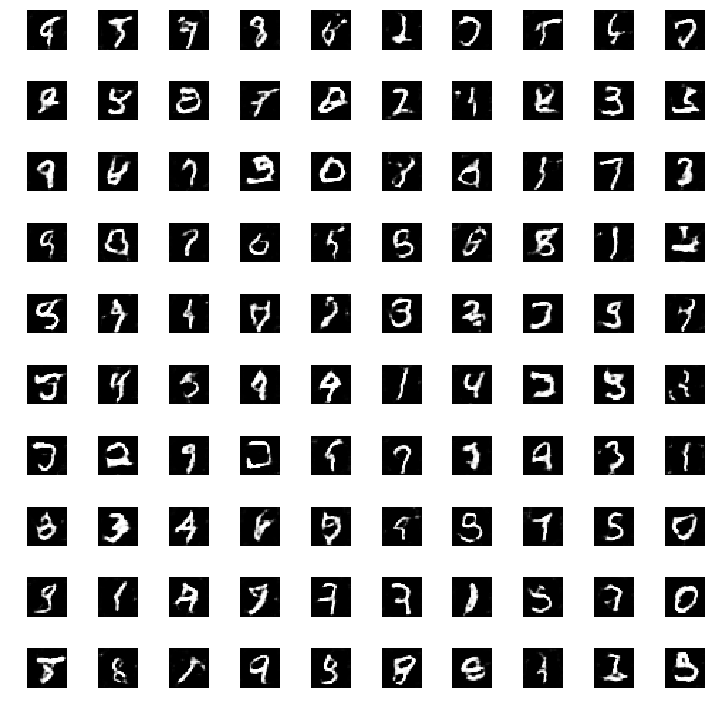

Epoch 11 -> Discriminator Loss : 0.5077 & Generator Loss : 1.9011
Epoch 12 -> Discriminator Loss : 0.5166 & Generator Loss : 1.9587
Epoch 13 -> Discriminator Loss : 0.5224 & Generator Loss : 1.9787
Epoch 14 -> Discriminator Loss : 0.5054 & Generator Loss : 1.9225
Epoch 15 -> Discriminator Loss : 0.5032 & Generator Loss : 1.9676


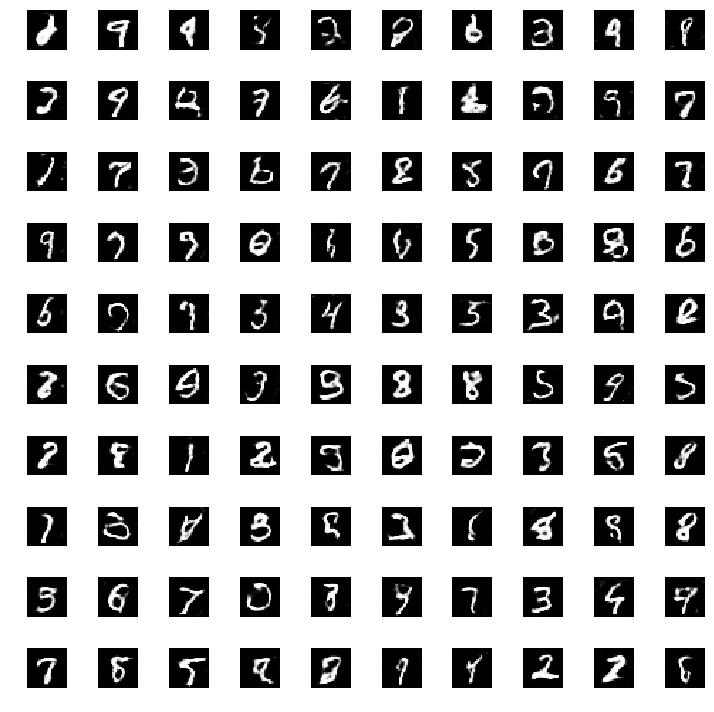

Epoch 16 -> Discriminator Loss : 0.5149 & Generator Loss : 1.9697
Epoch 17 -> Discriminator Loss : 0.4883 & Generator Loss : 1.9738
Epoch 18 -> Discriminator Loss : 0.5177 & Generator Loss : 2.0046
Epoch 19 -> Discriminator Loss : 0.5064 & Generator Loss : 1.9454
Epoch 20 -> Discriminator Loss : 0.4893 & Generator Loss : 2.0007


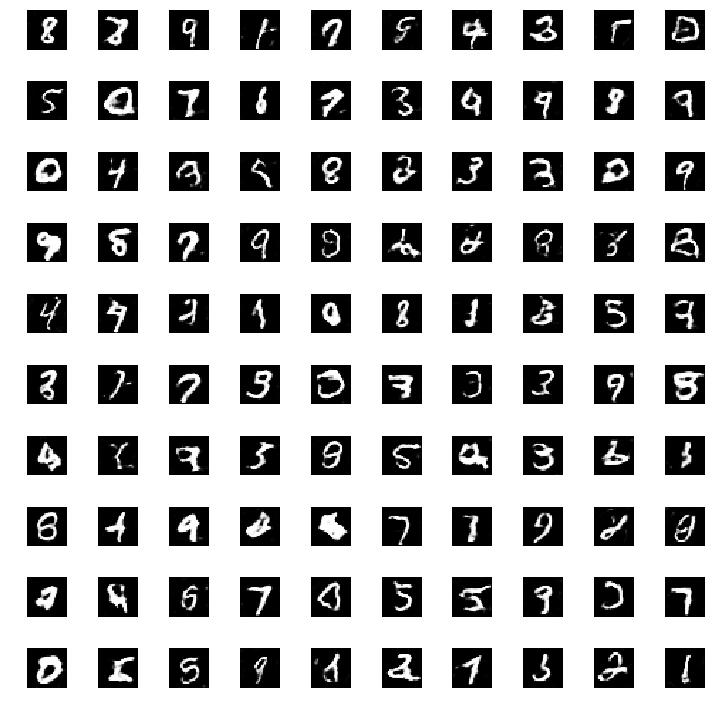

Epoch 21 -> Discriminator Loss : 0.5117 & Generator Loss : 2.0398
Epoch 22 -> Discriminator Loss : 0.5000 & Generator Loss : 1.9799
Epoch 23 -> Discriminator Loss : 0.4915 & Generator Loss : 2.0208
Epoch 24 -> Discriminator Loss : 0.5119 & Generator Loss : 2.0385
Epoch 25 -> Discriminator Loss : 0.4948 & Generator Loss : 1.9912


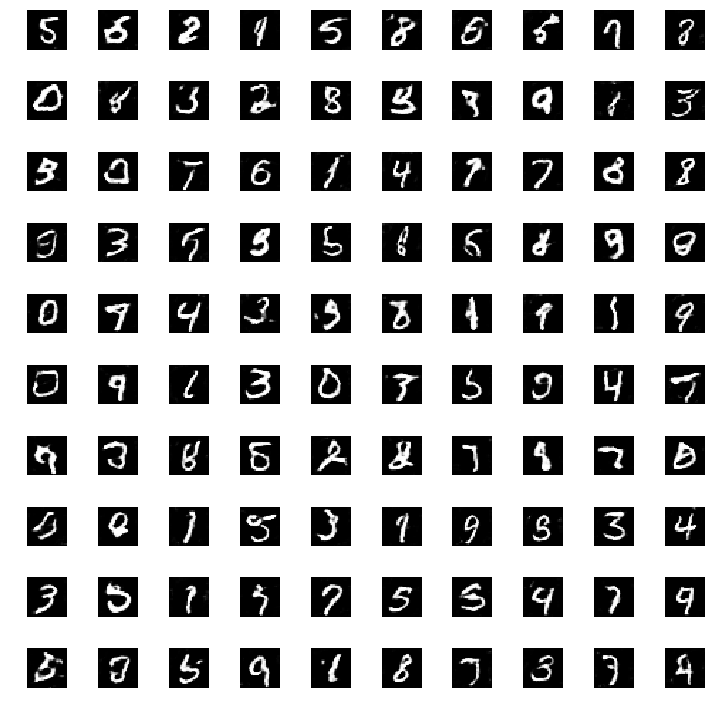

Epoch 26 -> Discriminator Loss : 0.4784 & Generator Loss : 2.0367
Epoch 27 -> Discriminator Loss : 0.4940 & Generator Loss : 2.0674
Epoch 28 -> Discriminator Loss : 0.4878 & Generator Loss : 2.0651
Epoch 29 -> Discriminator Loss : 0.4865 & Generator Loss : 2.0842
Epoch 30 -> Discriminator Loss : 0.5020 & Generator Loss : 2.0908


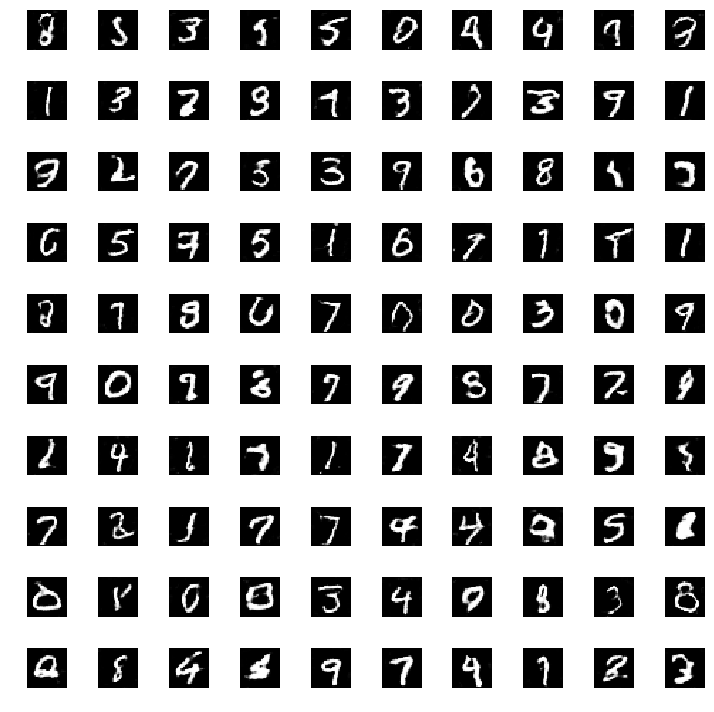

Epoch 31 -> Discriminator Loss : 0.4813 & Generator Loss : 2.0771
Epoch 32 -> Discriminator Loss : 0.4648 & Generator Loss : 2.1257
Epoch 33 -> Discriminator Loss : 0.4910 & Generator Loss : 2.1512
Epoch 34 -> Discriminator Loss : 0.4609 & Generator Loss : 2.1303
Epoch 35 -> Discriminator Loss : 0.4585 & Generator Loss : 2.1941


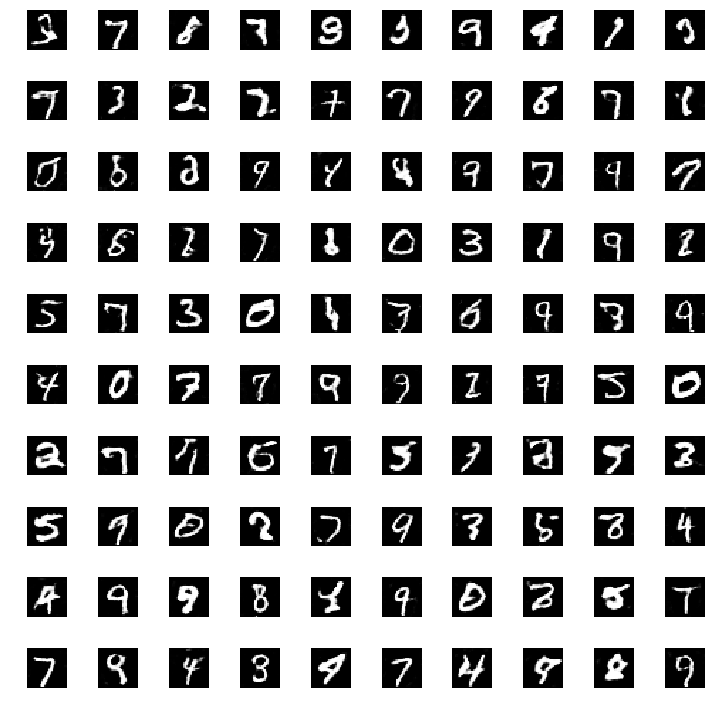

Epoch 36 -> Discriminator Loss : 0.4651 & Generator Loss : 2.2327
Epoch 37 -> Discriminator Loss : 0.4567 & Generator Loss : 2.2124
Epoch 38 -> Discriminator Loss : 0.4541 & Generator Loss : 2.2727
Epoch 39 -> Discriminator Loss : 0.4561 & Generator Loss : 2.2881
Epoch 40 -> Discriminator Loss : 0.4608 & Generator Loss : 2.3118


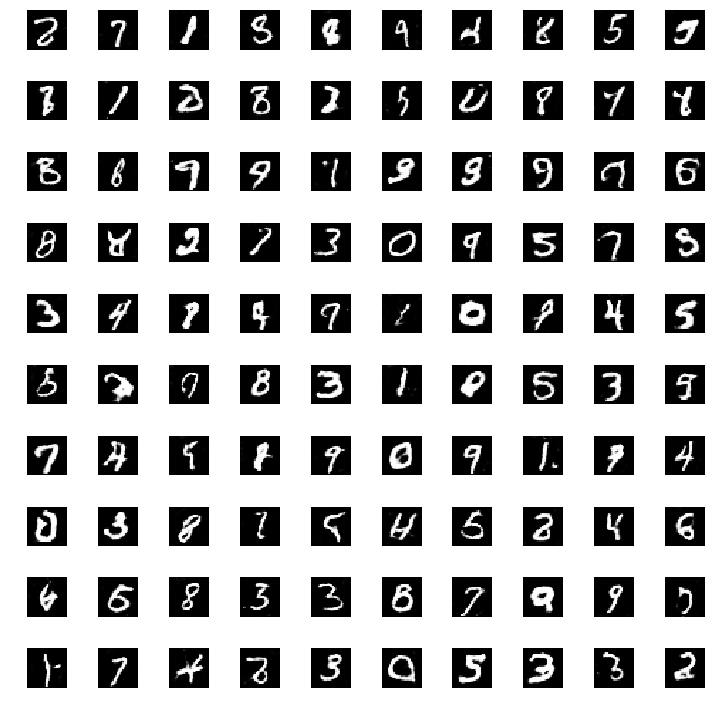

Epoch 41 -> Discriminator Loss : 0.4548 & Generator Loss : 2.2785
Epoch 42 -> Discriminator Loss : 0.4696 & Generator Loss : 2.2713
Epoch 43 -> Discriminator Loss : 0.4350 & Generator Loss : 2.3095
Epoch 44 -> Discriminator Loss : 0.4534 & Generator Loss : 2.3452
Epoch 45 -> Discriminator Loss : 0.4441 & Generator Loss : 2.3451


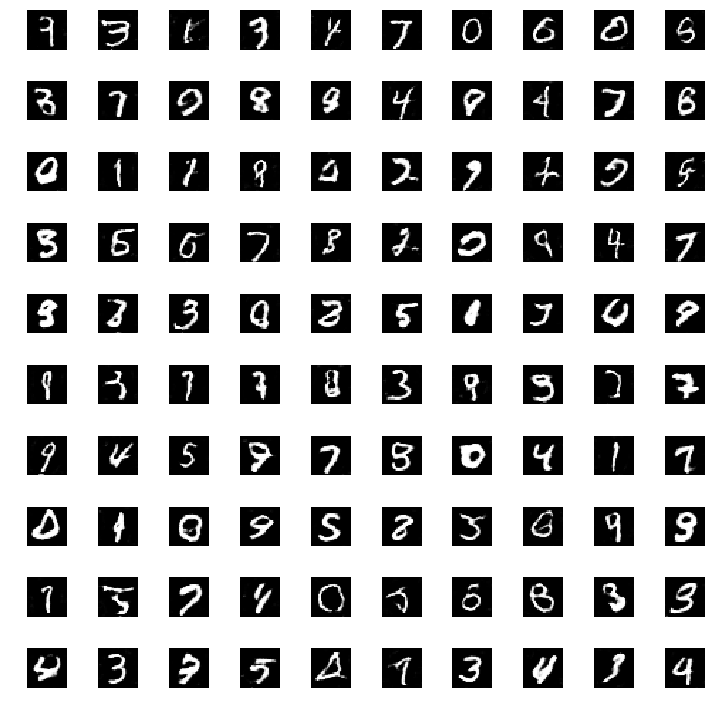

Epoch 46 -> Discriminator Loss : 0.4446 & Generator Loss : 2.3733
Epoch 47 -> Discriminator Loss : 0.4386 & Generator Loss : 2.4094
Epoch 48 -> Discriminator Loss : 0.4291 & Generator Loss : 2.3913
Epoch 49 -> Discriminator Loss : 0.4314 & Generator Loss : 2.4447
Epoch 50 -> Discriminator Loss : 0.4317 & Generator Loss : 2.4566


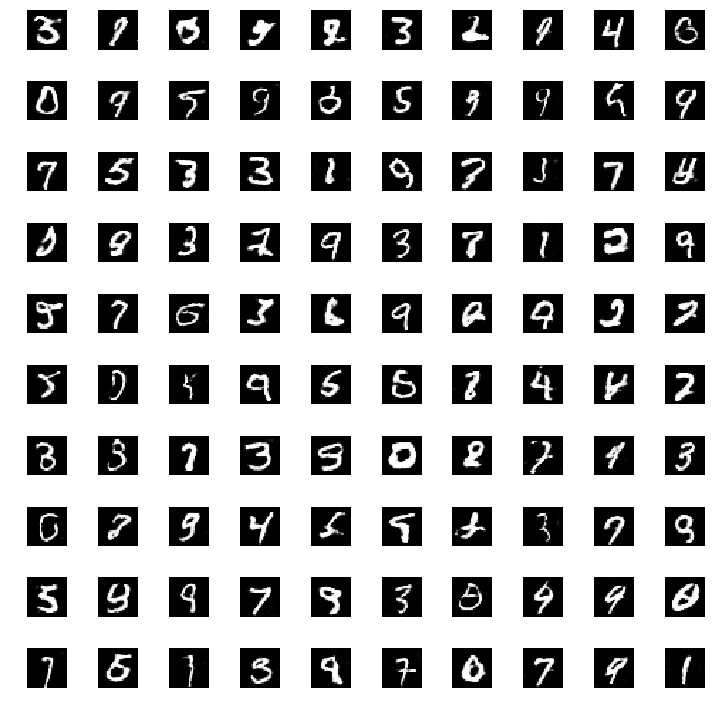

In [13]:
# Training Loop
d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    
    # Mini Batch SGD
    for step in range(NO_OF_BATCHES):
        
        # Step-1 Discriminator
        # 50% Real Data + 50% Fake Data
        
        # Real Data X
        # idx = np.random.randint(low, high, no_of_numbers)
        idx = np.random.randint(0, X_Train.shape[0], HALF_BATCH)
        real_imgs = X_Train[idx]
        
        # Fake Data X
        noise = np.random.normal(0,1,size=(HALF_BATCH, NOISE_DIM))
        fake_imgs = generator.predict(noise) # Forward
        
        # Labels
        real_y = np.ones((HALF_BATCH, 1)) * 0.9 # One sided label smoothing for Discriminator
        fake_y = np.zeros((HALF_BATCH, 1))
        
        # Train our Discriminator
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)
        
        epoch_d_loss += d_loss
        
        # Step-2 : Train Generator (Considering Frozen Discriminator)
        noise = np.random.normal(0,1,size=(BATCH_SIZE, NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise, ground_truth_y)
        epoch_g_loss += g_loss
    
    print("Epoch %d -> Discriminator Loss : %.4f & Generator Loss : %.4f"%((epoch+1),(epoch_d_loss/NO_OF_BATCHES),(epoch_g_loss/NO_OF_BATCHES)))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
    
    if(epoch+1)%5 == 0:
        generator.save('model/dcgan_tc_generator_{0}.h5'.format(epoch+1))
        save_images(epoch)

In [14]:
!zip -r /content/images.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/dcgan_tc_output_epoch_50.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_10.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_20.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_5.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_15.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_30.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_25.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_40.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_45.png (deflated 8%)
  adding: content/images/dcgan_tc_output_epoch_35.png (deflated 8%)


In [0]:
from google.colab import files

In [0]:
files.download('images.zip')

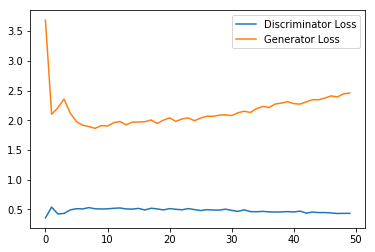

In [17]:
plt.plot(d_losses,label="Discriminator Loss")
plt.plot(g_losses,label="Generator Loss")
plt.legend()
plt.show()

In [18]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/dcgan_tc_generator_50.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_5.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_40.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_10.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_15.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_25.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_20.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_30.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_45.h5 (deflated 8%)
  adding: content/model/dcgan_tc_generator_35.h5 (deflated 8%)


In [0]:
files.download('model.zip')